The codes for split it to traning, testing, validating are available at utility/mat_data.py create_WDC_dataset(). 

Run the createDCmall() function in utility/lmdb_data.py to generate training lmdb dataset. 

To generate testing files with noise, replace the srcdir and dstdir in utility/generate_case.py and run utility/generate_case.py.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import xarray as xr
import rasterio
from rasterio.transform import from_origin
from hypso import Hypso1
from skimage import io
from osgeo import gdal
import warnings
from rasterio.errors import NotGeoreferencedWarning
import torch
import lmdb
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

In [18]:
dir_path = '/home/lofty/CODE/HyperSIGMA-fork/ImageDenoising/data/HSI_Data/Hyperspectral_Project/HYPSO2/'
wdc_path = '/home/lofty/CODE/HyperSIGMA-fork/ImageDenoising/data/HSI_Data/Hyperspectral_Project/WDC/'

hypso_case1= dir_path + 'test_noise/Cases/Case1/test.mat'
hypso_case2= dir_path + 'test_noise/Cases/Case2/test.mat'
hypso_case3= dir_path + 'test_noise/Cases/Case3/test.mat'
hypso_case4= dir_path + 'test_noise/Cases/Case4/test.mat'
hypso_case5= dir_path + 'test_noise/Cases/Case5/test.mat'

hypso_patch_case5 = dir_path + 'test_noise/Patch_Cases/Case5/'
hypso_patch_case5_0 =hypso_patch_case5+'test_0.mat'

hypso_result_case1 = dir_path+ '/results/hypersigma/hypersigma_Case1.mat'
hypso_result_case2 = dir_path+ '/results/hypersigma/hypersigma_Case2.mat'
hypso_result_case3 = dir_path+ '/results/hypersigma/hypersigma_Case3.mat'
hypso_result_case4 = dir_path+ '/results/hypersigma/hypersigma_Case4.mat'
hypso_result_case5 = dir_path+ '/results/hypersigma/hypersigma_Case5.mat'

wdc_case5 = wdc_path + 'test_noise/Cases/Case5/test.mat'
wdc_patch_case5 = wdc_path + 'test_noise/Patch_Cases/Case5/'
wdc_patch_case5_0=wdc_patch_case5+'test_0.mat'


In [ ]:
def process_hypso_images(dir_path, image_name, image_name2):
    """
    Processes HYPSO images and saves them as GeoTIFF files.

    Parameters:
    - dir_path: str, directory path where the images and points file are located.
    - image_name: str, base name of the first image file (without extension).
    - image_name2: str, base name of the second image file (without extension).
    """
    l1a_nc_file = os.path.join(dir_path, image_name + '.nc')
    points_file = os.path.join(dir_path, 'sift-bin.points')
    
    if not os.path.exists(l1a_nc_file):
        raise FileNotFoundError(f"The file {l1a_nc_file} does not exist.")
    if not os.path.exists(points_file):
        raise FileNotFoundError(f"The file {points_file} does not exist.")
    
    # Create Satellite Object
    satobj = Hypso1(path=l1a_nc_file, verbose=True)
    satobj.load_points_file(path=points_file, image_mode='standard', origin_mode='qgis')
    
    l1a_cube = satobj.get_l1a_cube()
    height, width, bands = l1a_cube.shape
    
    satobj.generate_l1b_cube()
    l1b_cube = satobj.get_l1b_cube()
    height_b, width_b, bands_b = l1b_cube.shape
    
    # Define the output GeoTIFF file paths
    output_tif = os.path.join(dir_path, image_name + '.tif')
    output_tif2 = os.path.join(dir_path, image_name2 + '.tif')
    
    # Save the first image as a GeoTIFF file
    with rasterio.open(
        output_tif,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=bands,
        dtype='uint16',
        crs=None
    ) as dst:
        for i in range(bands):
            dst.write(l1a_cube[:, :, i], i + 1)
    
    # Save the second image as a GeoTIFF file
    with rasterio.open(
        output_tif2,
        'w',
        driver='GTiff',
        height=height_b,
        width=width_b,
        count=bands_b,
        dtype='uint16',
        crs=None
    ) as dst:
        for i in range(bands_b):
            dst.write(l1b_cube[:, :, i], i + 1)

# Example usage
process_hypso_images(dir_path, 'virginiabeach_2024-08-22T14-59-41Z-l1a', 'virginiabeach_2024-08-22T14-59-41Z-l1b')

In [ ]:
def transpose_geotiff(input_path):
    """
    Transposes a GeoTIFF image and saves the result to a new file.
    
    Parameters:
    - input_path: str, path to the input GeoTIFF file.
    """
    output_path = input_path.replace('.tif', '_transposed.tif')
    with rasterio.open(input_path) as src:
        # Read the image data
        image_data = src.read()
        print(f"Original shape: {image_data.shape}")
        
        # Transpose the image data
        transposed_data = image_data.transpose((0, 2, 1))
        
        print(f"Shape after transposing: {transposed_data.shape}")
        # Update the metadata to reflect the new dimensions
        metadata = src.meta.copy()
        metadata.update({
            'height': transposed_data.shape[1],
            'width': transposed_data.shape[2],
            'count': transposed_data.shape[0]
        })
        # Write the transposed image to a new file
        with rasterio.open(output_path, 'w', **metadata) as dst:
            dst.write(transposed_data)

transpose_geotiff()

In [53]:
def resize_geotiff(input_path, desired_bands, desired_height, desired_width, padding_value=0):
    """
    Resizes a GeoTIFF image by cropping or padding to the desired dimensions.
    
    Parameters:
    - input_path: str, path to the input GeoTIFF file.
    - desired_bands: int, desired number of bands in the output image.
    - desired_height: int, desired height of the output image.
    - desired_width: int, desired width of the output image.
    - padding_value: int, value to use for padding (default is 0).
    """
    output_path = input_path.replace('.tif', '_resized.tif')
    
    with rasterio.open(input_path) as src:
        # Read the image data
        image_data = src.read()
        original_bands, original_height, original_width = image_data.shape
        
        # Crop or pad the bands
        if desired_bands < original_bands:
            image_data = image_data[:desired_bands, :, :]
        elif desired_bands > original_bands:
            band_padding = desired_bands - original_bands
            image_data = np.pad(
                image_data,
                ((0, band_padding), (0, 0), (0, 0)),
                mode='constant',
                constant_values=padding_value
            )
        
        # Crop or pad the height and width
        if desired_height < original_height:
            image_data = image_data[:, :desired_height, :]
        elif desired_height > original_height:
            height_padding = desired_height - original_height
            image_data = np.pad(
                image_data,
                ((0, 0), (0, height_padding), (0, 0)),
                mode='constant',
                constant_values=padding_value
            )
        
        if desired_width < original_width:
            image_data = image_data[:, :, :desired_width]
        elif desired_width > original_width:
            width_padding = desired_width - original_width
            image_data = np.pad(
                image_data,
                ((0, 0), (0, 0), (0, width_padding)),
                mode='constant',
                constant_values=padding_value
            )
        
        # Update the metadata to reflect the new dimensions
        metadata = src.meta.copy()
        metadata.update({
            'count': desired_bands,
            'height': desired_height,
            'width': desired_width
        })
        
        # Write the resized image to a new file
        with rasterio.open(output_path, 'w', **metadata) as dst:
            dst.write(image_data)

# Example usage
resize_geotiff(, desired_bands=191, desired_height=1280, desired_width=307, padding_value=0)

In [ ]:
def print_geotiff_info(file_path):
    # Open the GeoTIFF file
    print("--------------------")
    print(f"FILE: {os.path.basename(file_path)}")
    
    with rasterio.open(file_path) as dataset:
        img=dataset.read()
        # print(f"Metadata: {dataset.meta}")
        print(f"raster shape:   {img.shape}")
        # print(f"raster Shape: {dataset.shape}")
        # print(f"raster width: {dataset.width}")
        # print(f"raster height: {dataset.height}")
        # print(f"raster count: {dataset.count}")
    
    dataset = gdal.Open(file_path)
    array = dataset.ReadAsArray()
    print(f"gdal shape:     {array.shape}")
    
    ioimage = io.imread(file_path, plugin='tifffile')
    print(f"skimage shape:  {ioimage.shape}") 

In [ ]:
def plot_geotiff(file_path, band_index=3):
    """
    Plots the specified band of a GeoTIFF file.
    
    Parameters:
    - file_path: str, path to the GeoTIFF file.
    - band_index: int, index of the band to plot (default is 50).
    """
    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        # Read the specified band
        band = src.read(band_index)
        
        # Plot the band
        plt.imshow(band, cmap='Spectral')
        plt.title(f'{os.path.basename(file_path)} Band {band_index}')
        plt.axis('off')
        plt.show()
    # Plot the metadata
    metadata = src.meta
    # print("GeoTIFF Metadata:")
    # for key, value in metadata.items():
        # print(f"{key}: {value}")

# Example usage

In [ ]:
%run ./utility/mat_data.py

In [ ]:
%run  ./utility/lmdb_data.py

In [ ]:
%run  ./utility/generate_case.py

In [39]:
def slice_and_save_mat_image(input_path, cube_size=64):
    """
    Slices a .mat image into 64x64 cubes and saves them with the same keys and bands as the original.
    
    Parameters:
    - input_path: str, path to the input .mat file.
    - cube_size: int, size of the cubes (default is 64).
    """
    # Load the .mat file
    data = scipy.io.loadmat(input_path)
    
    # Extract the keys and their corresponding arrays
    keys = [key for key in data.keys() if not key.startswith('__')]
    arrays = {key: data[key] for key in keys}
    
    # Determine the output directory
    output_dir = input_path.replace('Cases', 'Patch_Cases').replace('test.mat', '')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Initialize a counter for the output files
    counter = 0
    
    # Get the shape of the arrays (assuming all arrays have the same shape)
    _, height, width = next(iter(arrays.values())).shape
    
    # Slice the arrays into cubes and save them
    for i in range(0, height, cube_size):
        for j in range(0, width, cube_size):
            # Create a dictionary to save the cube with the same keys
            cube_dict = {}
            for key in keys:
                array = arrays[key]
                cube = array[:, i:i+cube_size, j:j+cube_size]
                
                # Ensure the cube has the correct dimensions
                if cube.shape[1] == cube_size and cube.shape[2] == cube_size:
                    cube_dict[key] = cube
            
            if cube_dict:
                # Determine the output file path
                output_path = os.path.join(output_dir, f'test_{counter}.mat')
                
                # Save the cube as a .mat file
                scipy.io.savemat(output_path, cube_dict)
                
                # Increment the counter
                counter += 1

# Example usage
slice_and_save_mat_image(hypso_case1)
slice_and_save_mat_image(hypso_case2)
slice_and_save_mat_image(hypso_case3)
slice_and_save_mat_image(hypso_case4)
slice_and_save_mat_image(hypso_case5)

In [ ]:
!bash train_complex.sh 1e-4 hypersigma 0 l2 1 './data/HSI_Data/Hyperspectral_Project/HYPSO2/hypso.db'

In [14]:
!bash test.sh hypersigma ./output/original_hypersigma_1e-4_spat-base_batch4_warmup_l2_epoch_1_complex_s3_8point_HYPSO2/hypersigma_gaussian/model_latest.pth

----options----
Namespace(prefix='hypersigma_gaussian', arch='hypersigma', batchSize=16, lr=0.0001, wd=0, loss='l2', testdir='./data/HSI_Data/Hyperspectral_Project/HYPSO2/test_noise/Patch_Cases/Case1', sigma=None, training_dataset_path='/home/lofty/CODE/HyperSIGMA-fork/ImageDenoising/data/HSI_Data/Hyperspectral_Project/WDC/wdc_64.db', pretrain='/home/lofty/CODE/HyperSIGMA-fork/ImageDenoising/pre_train/checkpoint-400.pth', init='kn', no_cuda=False, from_scratch=False, pretrain_path='/home/lofty/CODE/HyperSIGMA-fork/spat-base.pth', no_log=False, threads=1, seed=2018, resume=True, no_ropt=False, chop=False, resumePath='./output/original_hypersigma_1e-4_spat-base_batch4_warmup_l2_epoch_1_complex_s3_8point_HYPSO2/hypersigma_gaussian/model_latest.pth', dataroot='/data/HSI_Data/ICVL64_31.db', clip=1000000.0, gpu_ids=[0], basedir='./data/HSI_Data/Hyperspectral_Project/HYPSO2/results', epoch=100, update_lr=5e-05, meta_lr=5e-05, n_way=1, k_spt=2, k_qry=5, task_num=16, update_step=5, update_step_

In [8]:
def plot_rgb_composite(path, keys, red_band=69, green_band=46, blue_band=26, output=False):
    # Load the .mat file
    data = scipy.io.loadmat(path)
    
    # Extract the 3D arrays using the provided keys
    rgb_images = []
    for key in keys:
        array = data[key]
        if output:
            red = array[:, :, red_band]
            green = array[:, :, green_band]
            blue = array[:, :, blue_band]
        else:
            red = array[red_band, :, :]
            green = array[green_band, :, :]
            blue = array[blue_band, :, :]
        rgb_image = np.stack((red, green, blue), axis=-1)
        rgb_images.append(rgb_image)
    
    # Plot the images side by side
    if len(rgb_images) == 1:
        plt.imshow(rgb_images[0])
        plt.title(f'{keys[0]}')
        plt.axis('off')
    else:
        fig, axes = plt.subplots(1, len(rgb_images), figsize=(15, 5))
        for ax, rgb_image, key in zip(axes, rgb_images, keys):
            ax.imshow(rgb_image)
            ax.set_title(f'{key}')
            ax.axis('off')
    # Include the shape of 'gt' as a label
    if 'gt' in keys:
        gt_shape = data['gt'].shape
        plt.figtext(0.5, 0.01, f'Shape of gt: {gt_shape}', ha='center', fontsize=12)
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0501947402954102..2.043506145477295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10305630415678024..1.1883585453033447].


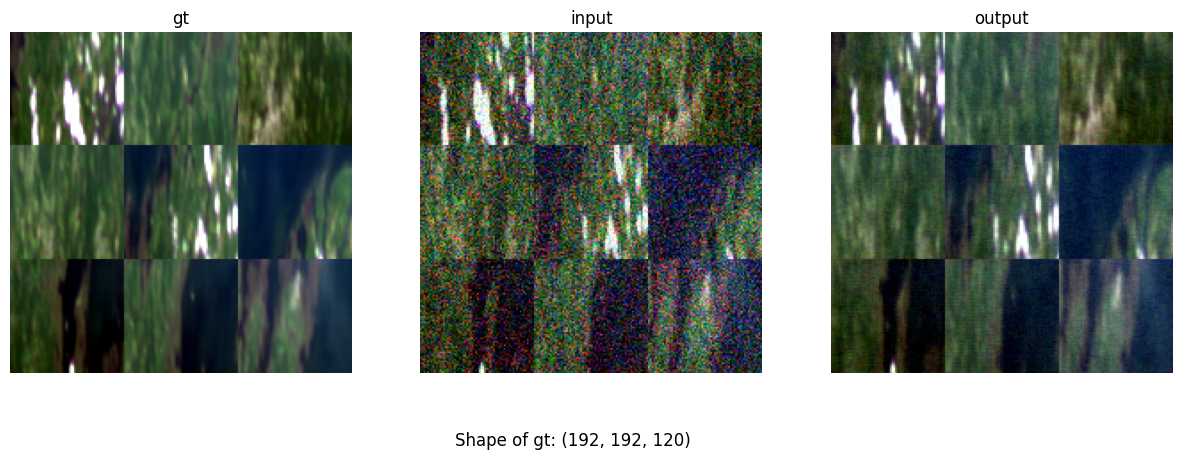

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.968149721622467..1.7691726684570312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10982044786214828..1.212133765220642].


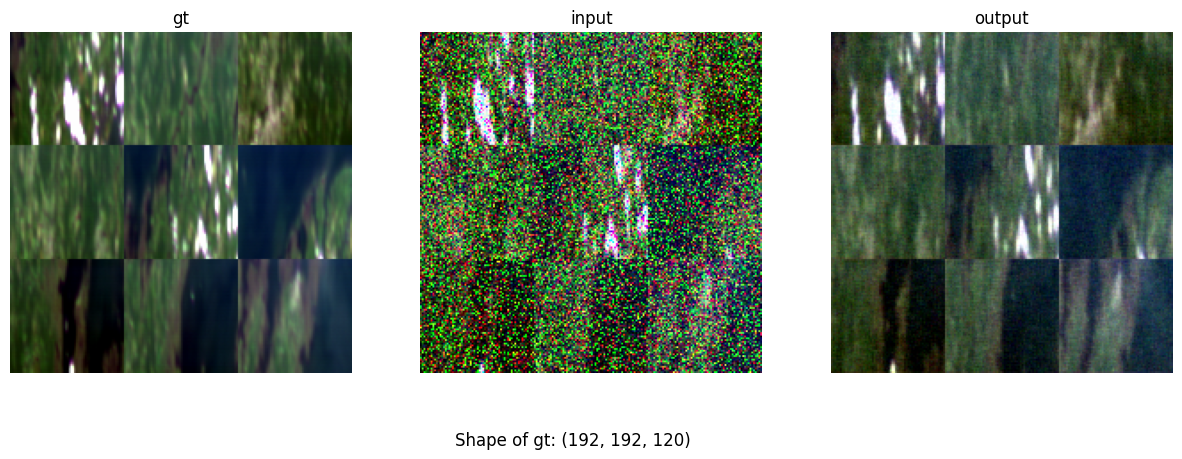

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6829991340637207..1.6766541004180908].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09904170781373978..1.1108201742172241].


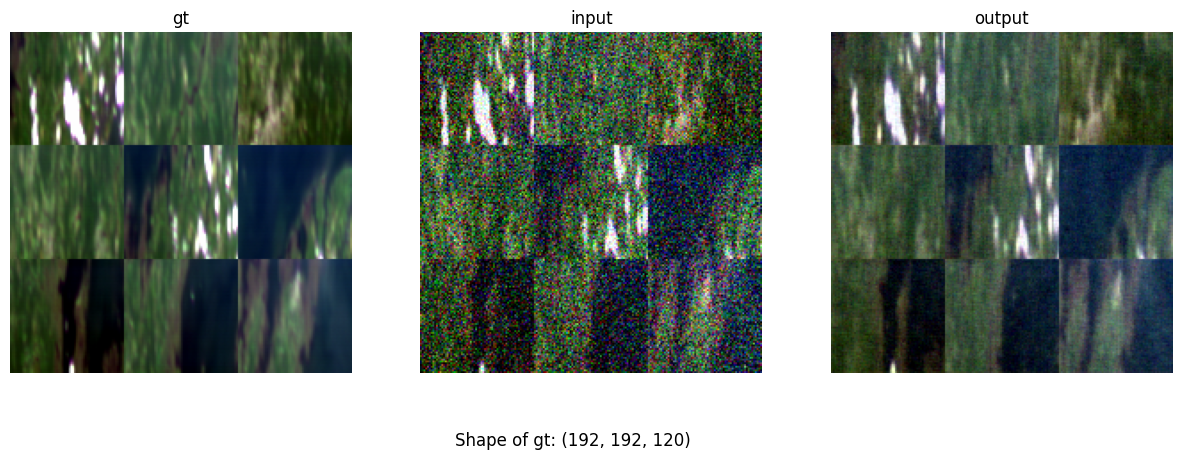

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0498576164245605..2.110947370529175].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1121591255068779..1.2028632164001465].


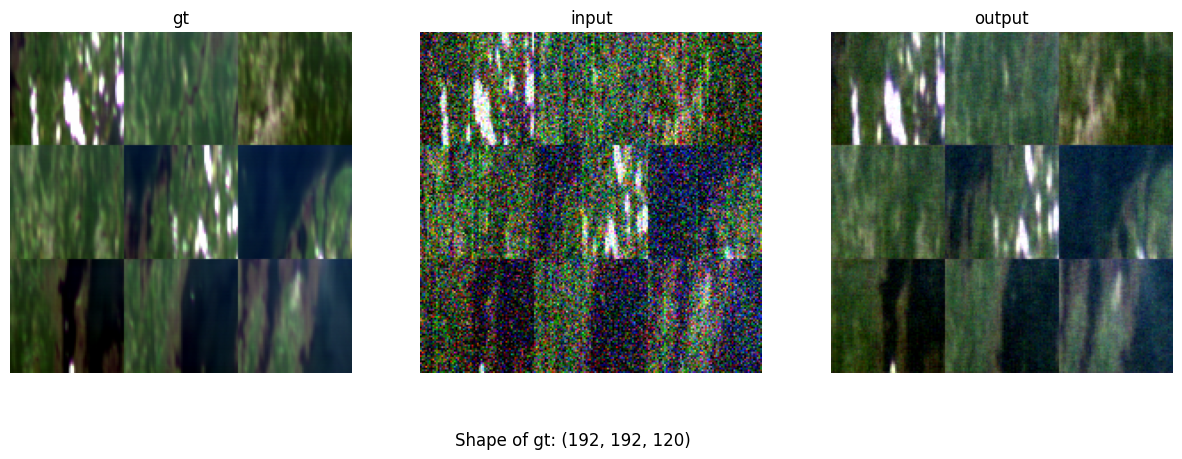

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6077049970626831..1.756643295288086].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12458214163780212..1.1881848573684692].


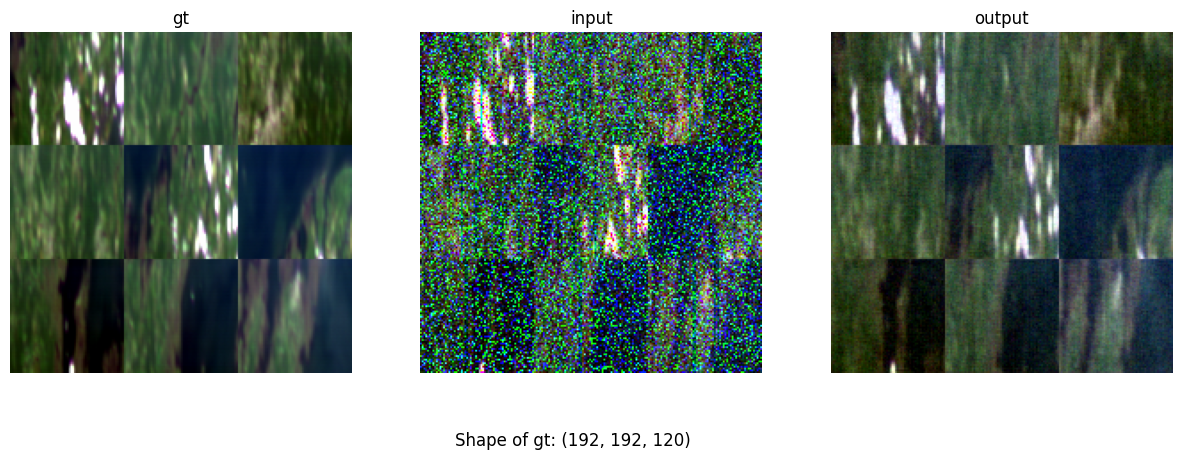

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6077050029476114..1.7566432628341586].


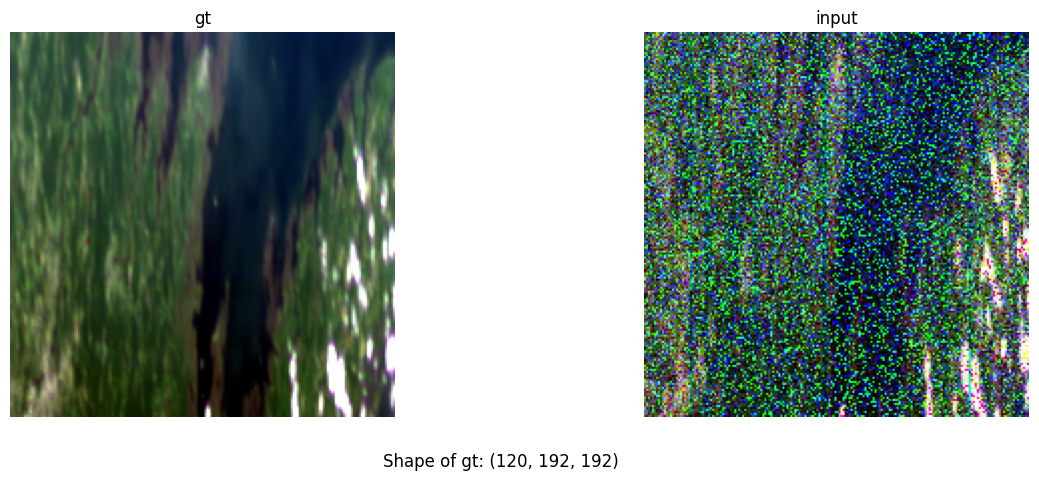

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46945324963926416..1.0].


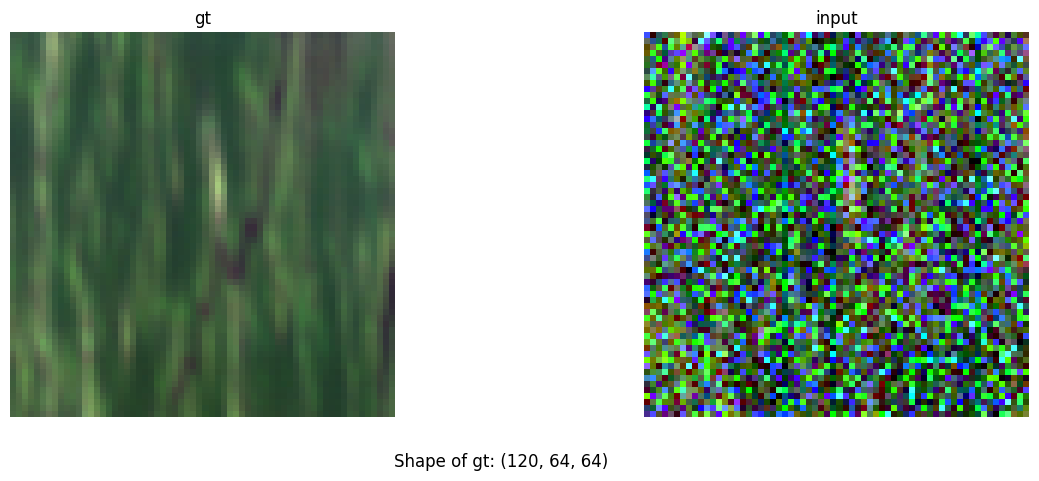

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3683372505958764..2.0732743061564674].


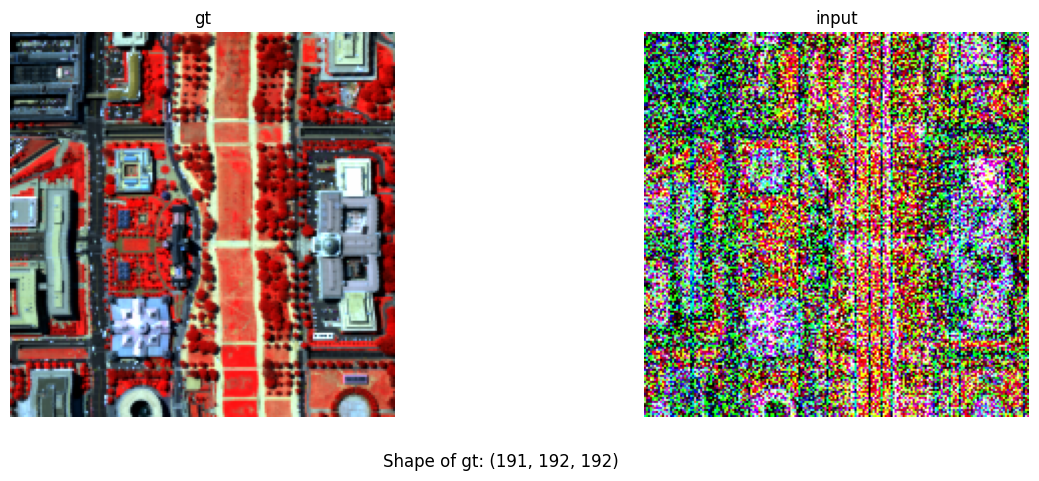

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9172890538085892..1.836311885506729].


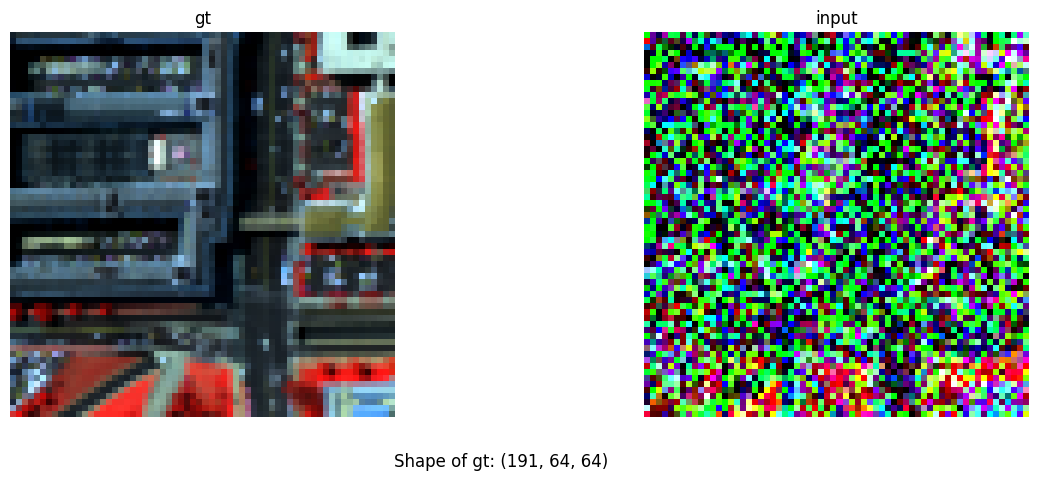

In [19]:
plot_rgb_composite(hypso_result_case1, ['gt', 'input', 'output'], output=True)
plot_rgb_composite(hypso_result_case2, ['gt', 'input', 'output'], output=True)
plot_rgb_composite(hypso_result_case3, ['gt', 'input', 'output'], output=True)
plot_rgb_composite(hypso_result_case4, ['gt', 'input', 'output'], output=True)
plot_rgb_composite(hypso_result_case5, ['gt', 'input', 'output'], output=True)

plot_rgb_composite(hypso_case5, ['gt', 'input'])
plot_rgb_composite(hypso_patch_case5_0, ['gt', 'input'])
plot_rgb_composite(wdc_case5, ['gt', 'input'])
plot_rgb_composite(wdc_patch_case5_0, ['gt', 'input'])


In [ ]:
plot_rgb_composite(
    './data/HSI_Data/Hyperspectral_Project/WDC/results/hypersigma/hypersigma_Case2.mat',
    keys=['gt', 'input', 'output'],
    red_band=30, green_band=20, blue_band=10, output=True
)
plot_rgb_composite(
    './data/HSI_Data/Hyperspectral_Project/WDC/results/hypersigma/hypersigma_Case3.mat',
    keys=['gt', 'input', 'output'],
    red_band=30, green_band=20, blue_band=10, output=True
)
plot_rgb_composite(
    './data/HSI_Data/Hyperspectral_Project/WDC/results/hypersigma/hypersigma_Case4.mat',
    keys=['gt', 'input', 'output'],
     red_band=30, green_band=20, blue_band=10, output=True
)
plot_rgb_composite(
    './data/HSI_Data/Hyperspectral_Project/WDC/results/hypersigma/hypersigma_Case5.mat',
    keys=['gt', 'input', 'output'],
     red_band=30, green_band=20, blue_band=10, output=True
)

In [22]:
def plot_hyperspectral_output(path, num_rows=3, num_cols=4, cmap='plasma'):
    """
    - Common colormaps include: 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'gray', 'hot', 'cool', 'spring', 'summer', 'autumn', 'winter'.
    """
    # Load the .mat file
    data = scipy.io.loadmat(path)
    
    # Extract the 'output' key
    output_data = data['output']
    
    # Plot the output data for 12 bands with equal spacing
    num_bands = output_data.shape[2]
    num_plots = num_rows * num_cols
    spacing = num_bands // num_plots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
    
    for i, ax in enumerate(axes.flat):
        band_index = i * spacing
        if band_index < num_bands:
            ax.imshow(output_data[:, :, band_index], cmap=cmap)
            ax.set_title(f'Output of {path.split("/")[-1]} - Band {band_index}')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_hyperspectral_output(
    './data/HSI_Data/Hyperspectral_Project/WDC/results/hypersigma/hypersigma_Case5.mat',
    num_rows=4, num_cols=4, cmap='viridis'
)

In [ ]:
def visualize_slices(shape, slices, slice_names):
    """
    Visualizes different slices of an image.

    Parameters:
    - shape: tuple, the shape of the image (bands, height, width).
    - slices: list of tuples, each tuple contains the slice indices (start_band, end_band, start_height, end_height, start_width, end_width).
    - slice_names: list of str, names of the slices for the legend.
    """
    # Create a base image with the same dimensions as the original image
    base_image = np.zeros((shape[1], shape[2]))

    # Assign different values to different slices for visualization
    for i, (start_band, end_band, start_height, end_height, start_width, end_width) in enumerate(slices):
        base_image[start_height:end_height, start_width:end_width] = i + 1

    # Plot the base image with different colors for each slice
    plt.figure(figsize=(10, 10))
    plt.imshow(base_image, cmap='tab10')
    plt.title('Slices in the Original Image')
    plt.axis('on')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')

    # Create a custom legend
    colors = [plt.cm.tab10(i) for i in range(len(slice_names))]
    patches = [mpatches.Patch(color=colors[i], label=slice_names[i]) for i in range(len(slice_names))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

# Example usage
shape = (191, 1280, 307)
slices = [
    (0, 191, 600, 800, 50, 250),  # Test slice
    (0, 191, 0, 600, 0, 307),     # Train slice 0
    (0, 191, 800, 1280, 0, 307),  # Train slice 1
    (0, 191, 600, 656, 251, 307)  # Validation slice
]
slice_names = ['Background', 'Test Slice', 'Train Slice 0', 'Train Slice 1', 'Validation Slice']

visualize_slices(shape, slices, slice_names)

shape = (120, 1092, 598)
slices = [
    (0, 120, 600, 800, 50, 250),  # Test slice
    (0, 120, 0, 600, 0, 598),     # Train slice 0
    (0, 120, 800, 1092, 0, 598),  # Train slice 1
    (0, 120, 600, 656, 251, 307)  # Validation slice
]
visualize_slices(shape, slices, slice_names)